In [18]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [19]:
class Pixelate:
    def __init__(self, transforms, n_between):
        self.transforms = transforms
        self.transforms.insert(0, self.set_image_to_random_grey)
        self.n_between = n_between
        self.n_transforms = len(transforms)
        self.T = self.n_transforms + (self.n_transforms - 1) * self.n_between

    def seed(self, seed):
        torch.manual_seed(seed)

    def set_image_to_random_grey(self, image):
        return image * 0 + torch.rand(1)

    def forward(self, image, t):
        """t is zero indexed from 0 to T-1"""
        fromIndex = t // (self.n_between + 1)
        interpolation = (t % (self.n_between + 1)) / (self.n_between + 1)
        fromImage = self.transforms[fromIndex](image)
        if interpolation == 0:
            return fromImage
        else:
            toIndex = fromIndex + 1
            toImage = self.transforms[toIndex](image)
            return (1 - interpolation) * fromImage + interpolation * toImage

In [20]:
interpolation = transforms.InterpolationMode.NEAREST
scales = [
    transforms.Compose(
        [
            transforms.Resize((8, 8), interpolation),
            transforms.Resize((32, 32), interpolation),
        ]
    ),
    transforms.Compose(
        [
            transforms.Resize((16, 16), interpolation),
            transforms.Resize((32, 32), interpolation),
        ]
    ),
    transforms.Resize((32, 32), interpolation),
]
N_transitions = 2
pixelate = Pixelate(scales, N_transitions)

In [21]:
mnist_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

In [22]:
def showImageList(images):
    # show images side by side
    fig = plt.figure(figsize=(20, 5))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.axis("off")
        ax.imshow(image.squeeze(), cmap="gray", vmin=0, vmax=1)

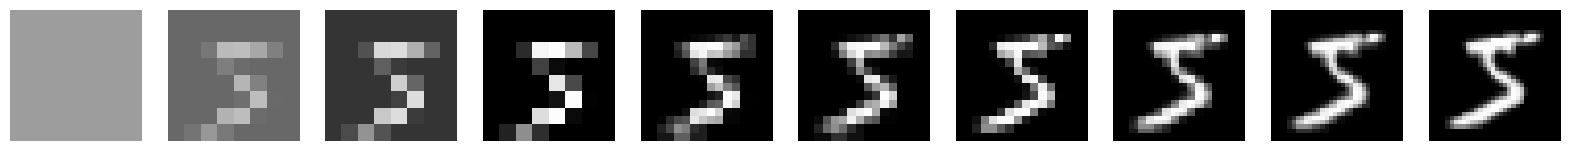

In [23]:
test_image = train_dataset[0][0]

showImageList([
    pixelate.seed(2) or pixelate.forward(test_image, t) for t in range(pixelate.T)
])